# SacFC - PROD Retention Score
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 6, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [4]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [5]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [6]:
lkupclientid = 31 # SACFC
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(12176, 53)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12176 entries, 0 to 12175
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            12176 non-null  int64  
 1   dimCustomerMasterId     12176 non-null  int64  
 2   year                    12176 non-null  int64  
 3   productGrouping         12176 non-null  object 
 4   totalSpent              12176 non-null  float64
 5   recentDate              12176 non-null  object 
 6   attendancePercent       12176 non-null  float64
 7   renewedBeforeDays       12176 non-null  int64  
 8   isBuyer                 12176 non-null  object 
 9   source_tenure           12176 non-null  int64  
 10  tenure                  12176 non-null  int64  
 11  distToVenue             0 non-null      object 
 12  totalGames              12176 non-null  int64  
 13  recency                 12176 non-null  int64  
 14  missed_games_1          12176 non-null

### We should specify the features used in our model:

In [8]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "attendancePercent",
            "clickToOpenRatio", 
            "clickToSendRatio", 
            "distToVenue",
            "inperson_contact", 
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "openToSendRatio",
            "phonecall",
            "recency",
            "source_tenure",
            "totalSpent",
            "recentDate",
            "isNextYear_Buyer",
            "productGrouping",
            "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8848, 18)
Unseen Data For Predictions: (1561, 18)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [9]:
loaded_model = load_model('model')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(display_types=False,
                                      features_todrop=['clientcode',
                                                       'dimCustomerMasterId',
                                                       'lkupclientid',
                                                       'productGrouping',
                                                       'year'],
                                      ml_usecase='classification',
                                      numerical_features=['attendancePercent',
                                                          'clickToOpenRatio',
                                                          'clickToSendRatio',
                                                          'distToVenue',
                                                          'inperson_contact',
                                                   

### Let's load in our 2021 season data and get retention scores using the model:

In [10]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(1767, 53)

In [12]:
new_predictions = predict_model(loaded_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,source_tenure,tenure,distToVenue,totalGames,recency,missed_games_1,missed_games_2,missed_games_over_2,click_link,fill_out_form,open_email,send_email,unsubscribe_email,openToSendRatio,clickToSendRatio,clickToOpenRatio,posting_records,resale_records,resale_atp,forward_records,cancel_records,email,inbound_email,inbound_phonecall,inperson_contact,internal_note,left_message,outbound_email,outbound_phonecall,phonecall,text,unknown,gender,childrenPresentInHH,maritalStatus,lengthOfResidenceInYrs,annualHHIncome,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
10409,31,457921355,2022,Half Season,324.00,2022-03-12,0.333333,58,TRUE,1095,1073,0,1,2,0,1,0,3,0,78,45,0,1.733333,0.066667,0.038462,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,0,0,0,0,0.0,0,22,0,0,0,0.8058,0.1942
10410,31,457921878,2022,Half Season,934.00,2022-04-30,0.666667,46,TRUE,1095,869,0,2,0,1,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,0,0,0,0,0.0,0,22,0,0,0,0.2639,0.7361
10411,31,457921976,2022,Full Season,4991.44,1970-01-01,0.000000,19,TRUE,2555,2728,0,0,0,0,0,0,3,0,57,48,0,1.187500,0.062500,0.052632,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,M,1,1,0,0,0,0,0.0,0,22,0,0,0,0.9975,0.0025
10412,31,457923372,2022,Half Season,734.00,2022-06-04,1.333333,51,TRUE,2555,2706,0,4,0,0,0,0,0,0,45,24,0,1.875000,0.000000,0.000000,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,F,1,1,0,0,0,0,0.0,0,22,0,0,0,0.9990,0.0010
10413,31,457924443,2022,Full Season,1450.00,2022-04-02,0.166667,193,TRUE,365,613,0,1,2,0,1,1,0,0,0,21,0,0.000000,0.000000,0.000000,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,0,0,0,0,0.0,0,22,0,0,0,0.6460,0.3540


In [13]:
new_predictions["Label"].value_counts()

0    1742
1      25
Name: Label, dtype: int64

In [14]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    1371
(0.2, 0.4]        236
(0.4, 0.6]         98
(0.6, 0.8]         53
(0.8, 1.0]          9
Name: Score_1, dtype: int64

In [15]:
new_predictions["Score_1"].value_counts(bins=[0, 0.05, 0.1, 0.15, 0.8, 1.0])

(-0.001, 0.05]    1087
(0.15, 0.8]        480
(0.1, 0.15]        117
(0.05, 0.1]         74
(0.8, 1.0]           9
Name: Score_1, dtype: int64

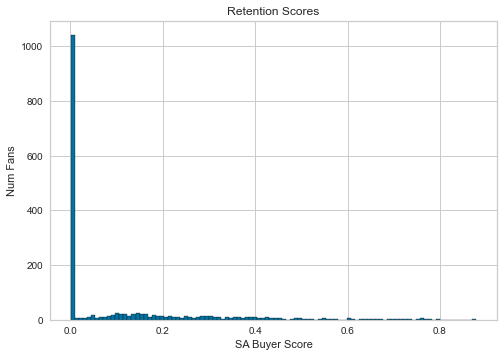

In [16]:
plt.hist(new_predictions["Score_1"], bins=100, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

## Observations
Here you can document some ideas on the results from above